# Confidence of a Bayesian Neural Network
This notebook examines the confidence calculation of a *Bayesian* neural network. I will use the *MNIST* and *FashionMNIST* datasets to demonstrate how confidence within the prediction process can help to avoid misclassification. `PyTorch` and `Pyro` are used for the probabilistic programming part.

# Probabilistic computation with Pyro

We will use [Pyro](https://pyro.ai/) for the probabilistic computation.

Import all necessary libraries.

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

from collections import OrderedDict

import time

# PyTorch
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torch.distributions import constraints

import helper

In [2]:
# Pyro
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

pyro.set_rng_seed(101)

Decide whether to use trained and saved parameter or not:

In [3]:
use_saved_params = True

Set the percentile value to determine the amount of parameters whose values should be substituted by zero.

In [4]:
percentile_val = 88

Get the Pyro version

In [5]:
pyro.__version__

'1.5.0'

Assign the device. It is either cuda:0 or cpu.

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Load the data

Use `Dataloader` to load the data and store it in the `data` directory.

The dataset is split into two parts, training and testing.

The testing sets is used to measure the model's performance on data it hasn't seen yet. 

Define how to transform the datasets.

In [7]:
transform = transforms.Compose(
    [transforms.ToTensor()])

Define the datasets and where to store them.

In [8]:
# datasets
trainset = torchvision.datasets.MNIST('../data',
    download=True,
    train=True,
    transform=transform)
testset = torchvision.datasets.MNIST('../data',
    download=True,
    train=False,
    transform=transform)

Load the datasets.

In [9]:
# dataloaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)

testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

Define the neural net. It is identical to the classic approach.

In [10]:
input_layer_size = 28*28 # image size of 28 x 28 pixels
hidden_layer_size = 1024 # number of hidden layer nodes
output_layer_size = 10   # number of categories

In [11]:
class NeuralNet(nn.Module):
    
    def __init__(self, input_layer, hidden_layer, output_layer):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_layer, hidden_layer)
        self.out = nn.Linear(hidden_layer, output_layer)
        
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.out(x)
        return x

In [12]:
log_softmax = nn.LogSoftmax(dim=1)

Instance new neural network for probabilistic calculations.

In [13]:
baysNeuralNet = NeuralNet(input_layer_size, hidden_layer_size, output_layer_size)

Move the network to `cuda`.

In [14]:
baysNeuralNet.to(device)

NeuralNet(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (out): Linear(in_features=1024, out_features=10, bias=True)
)

To do Bayesian inference in Pyro we need a *model*, a *guide*, an *optimizer*, and an *inference algorithm*.

### Model
In general a *model* in `Pyro` is a Python function which uses `Pyro` primitives (= primitive stochastic functions) to compute the input data.

One important thing to mention is that `pyro.sample` statements with an `obs` keyword are used to incorporate observations into the inference process. 

For Neural Networks we first need to convert our conventional network into a Bayesian network. Therefore we replace the fixed parameters for the weights and the biases by distributions. 

In our case we use the normal distribution to generate the priors.
```python
pyro.distributions.Normal()
```
After generating the priors, we replace the conventional, fixed parameters (weights and biases) by these new ones by calling 
```python
pyro.random_module()
```
Now we can create a sampled neural network module with sampled weights and biases and pass in data to generate a result.

In our case, the result will be 10 negative number representing the log probability of the 10 categories:

<img src='../pictures/mode-raw-output.png' width=700 align=left>

In [15]:
def model(x_data, y_data):
    
    # Initialize the prior distributions for the weights and biases of the neural network layers (N(0,1))
    fc1_weight_prior = dist.Normal(loc=torch.zeros(baysNeuralNet.fc1.weight.size()).to(device), 
                        scale=torch.ones(baysNeuralNet.fc1.weight.size()).to(device))
    fc1_bias_prior = dist.Normal(loc=torch.zeros(baysNeuralNet.fc1.bias.size()).to(device), 
                        scale=torch.ones(baysNeuralNet.fc1.bias.size()).to(device))

    
    out_weight_prior = dist.Normal(loc=torch.zeros(baysNeuralNet.out.weight.size()).to(device), 
                        scale=torch.ones(baysNeuralNet.out.weight.size()).to(device))
    out_bias_prior = dist.Normal(loc=torch.zeros(baysNeuralNet.out.bias.size()).to(device), 
                        scale=torch.ones(baysNeuralNet.out.bias.size()).to(device))
    
    priors = {'fc1.weight': fc1_weight_prior, 'fc1.bias': fc1_bias_prior,  
              'out.weight': out_weight_prior, 'out.bias': out_bias_prior}
    
    # place a prior over the parameters (weights and biases) of the network. 
    # Returns a distribution (callable) over nn.Module`s, which upon calling returns a sampled `nn.Module.
    priored_module = pyro.random_module("module", baysNeuralNet, priors)
    
    # get a sampled `nn.Module (callable) with sampled weights and biases 
    sampled_module = priored_module()
    
    # get the LogSoftmax result for each dataset (within a batch)
    # each cathegory is represented by a negative number. (Eg 10 numbers for the 10 digits 0-9)
    logProbPred = log_softmax(sampled_module(x_data))
    
    # incorporate observations into the model
    # Call the stochastic function Categorical and return a sampled result according to the distribution if
    # no obs parameter is set to condition on - otherwise use the obs argument to the pyro.sample statement 
    # to condition on the observed data y_data -> the result will by y_data
    # Categorical creates a categorical distribution parameterized by logits (log_softmax())
    pyro.sample("obs", dist.Categorical(logits=logProbPred), obs=y_data)

The result of pyro.sample **without** the observation argument will be stochastically sampled from `logProbPred` and will be different from `y_data`:
<img src='../pictures/cat_sample_without_obs.png' width=800px>
The result of pyro.sample **with** the observation argument will be identical to `y_data`:
<img src='../pictures/cat_sample_with_obs.png' width=800px>

### Guide
The *guide* is a parameterized family of distributions over the *weights* and the *biases* and it is used to train the model by learning the parameters declared by `pyro.param` given the observation outcomes `obs`. `pyro.param` registers the parameters in the [ParamStore](http://docs.pyro.ai/en/0.2.1-release/parameters.html). 

The parameters to be learned are *fcl1_w_mu*, *fcl1_w_sigma*, *fcl1_b_mu*, *fcl1_b_sigma*, *outl_w_mu*, *outl_w_sigma*, *outl_b_mu* and *outl_b_sigma* and are defined within the *guide*. 

In [16]:
softplus = torch.nn.Softplus()

def guide(x_data, y_data):
    
    # First layer weight distribution priors
    fc1_weight_loc = torch.randn(baysNeuralNet.fc1.weight.size()).to(device)
    fc1_weight_scale = torch.rand(baysNeuralNet.fc1.weight.size()).to(device)
    fc1_weight_loc_param = pyro.param("fc1_weight_loc", fc1_weight_loc)
    fc1_weight_scale_param = softplus(pyro.param("fc1_weight_scale", fc1_weight_scale, constraint=constraints.positive))
    fc1_weight_prior = dist.Normal(loc=fc1_weight_loc_param, scale=fc1_weight_scale_param)
    
    # First layer bias distribution priors
    fc1_bias_loc = torch.randn(baysNeuralNet.fc1.bias.size()).to(device)
    fc1_bias_scale = torch.rand(baysNeuralNet.fc1.bias.size()).to(device)
    fc1_bias_loc_param = pyro.param("fc1_bias_loc", fc1_bias_loc)
    fc1_bias_scale_param = softplus(pyro.param("fc1_bias_scale", fc1_bias_scale, constraint=constraints.positive))
    fc1_bias_prior = dist.Normal(loc=fc1_bias_loc_param, scale=fc1_bias_scale_param)
    
    # Output layer weight distribution priors
    out_weight_loc = torch.randn(baysNeuralNet.out.weight.size()).to(device)
    out_weight_scale = torch.rand(baysNeuralNet.out.weight.size()).to(device)
    out_weight_loc_param = pyro.param("out_weight_loc", out_weight_loc)
    out_weight_scale_param = softplus(pyro.param("out_weight_scale", out_weight_scale, constraint=constraints.positive))
    out_weight_prior = dist.Normal(loc=out_weight_loc_param, scale=out_weight_scale_param).independent(1)
    
    # Output layer bias distribution priors
    out_bias_loc = torch.randn(baysNeuralNet.out.bias.size()).to(device)
    out_bias_scale = torch.rand(baysNeuralNet.out.bias.size()).to(device)
    out_bias_loc_param = pyro.param("out_bias_loc", out_bias_loc)
    out_bias_scale_param = softplus(pyro.param("out_bias_scale", out_bias_scale, constraint=constraints.positive))
    out_bias_prior = dist.Normal(loc=out_bias_loc_param, scale=out_bias_scale_param)
    
    priors = {'fc1.weight': fc1_weight_prior, 'fc1.bias': fc1_bias_prior, 
              'out.weight': out_weight_prior, 'out.bias': out_bias_prior}
    
    priored_module = pyro.random_module("module", baysNeuralNet, priors)
    
    return priored_module()

### Optimizer & Inference Algorithm
In this example we use the *Adam* optimizer and the *Stochastic Variational Inference (SVI)*.

In [17]:
optim = Adam({"lr": 0.01})
svi = SVI(model, guide, optim, loss=Trace_ELBO())

### Training
Training is done by the *Stochastic Variational Inference (SVI)* optimization algorithm with the *ELBO* as the loss function (See the introductory part at the beginning of this notebook) by adjusting the `pyro.param` values.

In [18]:
if use_saved_params == False:

    num_iterations = 10
    loss = 0

    start = time.time()

    for j in range(num_iterations):
        loss = 0
        for batch_id, (images, labels) in enumerate(trainloader):
            # calculate the loss and take a gradient step

            images, labels = images.to(device), labels.to(device)

            loss += svi.step(images.view(-1,28*28), labels)

        normalizer_train = len(trainloader.dataset)
        total_epoch_loss_train = loss / normalizer_train

        print("Epoch ", j+1, " Loss ", total_epoch_loss_train)

    print("\nTime for training: {:.0f} minutes and {:.3f} seconds"
          .format((time.time() - start)/60, (time.time() - start) % 60))

### Save trained parameters to disc

In [19]:
if use_saved_params == False:
    pyro.get_param_store().save('saved_params.save')

### Load parameters from disk

In [20]:
if use_saved_params == True:
    pyro.get_param_store().load('saved_params.save')

### Check the trained parameters

Get the parameter names and check their sizes.

In [21]:
for name in pyro.get_param_store().get_all_param_names():
    print(name, pyro.param(name).cpu().detach().numpy().size)

fc1_weight_loc 802816
fc1_weight_scale 802816
fc1_bias_loc 1024
fc1_bias_scale 1024
out_weight_loc 10240
out_weight_scale 10240
out_bias_loc 10
out_bias_scale 10


Check the shape of the parameter space.

In [22]:
for name in pyro.get_param_store().get_all_param_names():
    print(name, pyro.param(name).cpu().detach().numpy().shape)

fc1_weight_loc (1024, 784)
fc1_weight_scale (1024, 784)
fc1_bias_loc (1024,)
fc1_bias_scale (1024,)
out_weight_loc (10, 1024)
out_weight_scale (10, 1024)
out_bias_loc (10,)
out_bias_scale (10,)


Get the first value of each parameter type.

In [23]:
for name in pyro.get_param_store().get_all_param_names():
    if len(pyro.param(name).cpu().detach().numpy().shape) == 1:
#         print('Size for parameter {} is {}'. format(name, pyro.param(name).cpu().detach().numpy().size))
        print('First value of parameter {} is {}'. format(name, pyro.param(name).cpu().detach().numpy()[0]))
    elif len(pyro.param(name).cpu().detach().numpy().shape) == 2:
#         print('Size for parameter {} is {}'. format(name, pyro.param(name).cpu().detach().numpy().size))
        print('First value of parameter {} is {}'. format(name, pyro.param(name).cpu().detach().numpy()[0, 0]))

First value of parameter fc1_weight_loc is -0.0892615020275116
First value of parameter fc1_weight_scale is 0.464173823595047
First value of parameter fc1_bias_loc is -0.39173540472984314
First value of parameter fc1_bias_scale is 0.4639877378940582
First value of parameter out_weight_loc is -0.012034603394567966
First value of parameter out_weight_scale is 0.2915618419647217
First value of parameter out_bias_loc is -0.11939097195863724
First value of parameter out_bias_scale is 0.44849273562431335


### Save the trained parameters

Save the learned parameters for further processing. 

In [24]:
fc1_weight_loc_temp = pyro.param('fc1_weight_loc').cpu().detach().numpy()
fc1_weight_scale_temp = pyro.param('fc1_weight_scale').cpu().detach().numpy()
fc1_bias_loc_temp = pyro.param('fc1_bias_loc').cpu().detach().numpy()
fc1_bias_scale_temp = pyro.param('fc1_bias_scale').cpu().detach().numpy()
out_weight_loc_temp = pyro.param('out_weight_loc').cpu().detach().numpy()
out_weight_scale_temp = pyro.param('out_weight_scale').cpu().detach().numpy()
out_bias_loc_temp = pyro.param('out_bias_loc').cpu().detach().numpy()
out_bias_scale_temp = pyro.param('out_bias_scale').cpu().detach().numpy()

Check minimum variance value.

In [25]:
print(np.min(fc1_weight_scale_temp))

0.008764488


### Signal-to-noise ratio
Calculate the signal to noise ratio for the fc1 weights according to [Blundell et al](https://arxiv.org/pdf/1505.05424.pdf)

In [26]:
fc1_weight_signal_noise_ratio = np.abs(fc1_weight_loc_temp) / fc1_weight_scale_temp
fc1_bias_signal_noise_ratio = np.abs(fc1_bias_loc_temp) / fc1_bias_scale_temp
out_weight_signal_noise_ratio = np.abs(out_weight_loc_temp) / out_weight_scale_temp
out_bias_signal_noise_ration = np.abs(out_bias_loc_temp) / out_bias_scale_temp
# print(fc1_weight_signal_noise_ratio)
# print(fc1_weight_signal_noise_ratio.shape)
print(np.min(fc1_weight_signal_noise_ratio))
print(np.max(fc1_weight_signal_noise_ratio))

5.0145854e-07
37.155296


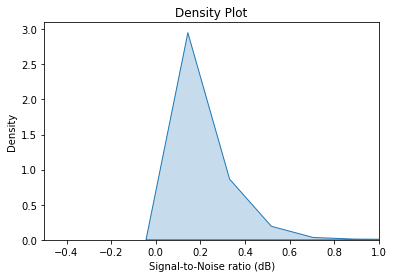

In [27]:
a = np.ravel(fc1_weight_signal_noise_ratio)
plt.xlim(-0.5, 1.0)
sns.kdeplot(x = a, shade="fill")

# Plot formatting
plt.title('Density Plot')
plt.xlabel('Signal-to-Noise ratio (dB)')
plt.ylabel('Density')
plt.show()

Calculate the mean for the signal to noise ratio.

In [28]:
fc1_weight_mean = np.mean(fc1_weight_signal_noise_ratio)
fc1_bias_mean = np.mean(fc1_bias_signal_noise_ratio)
out_weight_mean = np.mean(out_weight_signal_noise_ratio)
out_bias_mean = np.mean(out_bias_signal_noise_ration)
print(fc1_weight_mean)

0.1671208


Calculate the percentile for the signal to noise ratio.

In [29]:
fc1_weight_percentile = np.percentile(fc1_weight_signal_noise_ratio, percentile_val)
fc1_bias_percentile = np.percentile(fc1_bias_signal_noise_ratio, percentile_val)
out_weight_percentile = np.percentile(out_weight_signal_noise_ratio, percentile_val)
out_bias_percentile = np.percentile(out_bias_signal_noise_ration, percentile_val)
print('{}th percentile of fc1 weights: {}'.format(percentile_val, fc1_weight_percentile))
# np.savetxt('results.csv', [percentile_val], delimiter=',')

88th percentile of fc1 weights: 0.32299870252609236


Get the indexes of all signal to noise rations less than the mean value

In [30]:
fc1_weight_signal_noise_ratio_index = np.argwhere(fc1_weight_signal_noise_ratio < fc1_weight_percentile)
fc1_bias_signal_noise_ratio_index = np.argwhere(fc1_bias_signal_noise_ratio < fc1_bias_percentile)
out_weight_signal_noise_ratio_index = np.argwhere(out_weight_signal_noise_ratio < out_weight_percentile)
out_bias_signal_noise_ratio_index = np.argwhere(out_bias_signal_noise_ration < out_bias_percentile)

print('# of "deleted" weights between input and hidden layer: {} = {:.3} %'. 
      format(len(fc1_weight_signal_noise_ratio_index), 
             (len(fc1_weight_signal_noise_ratio_index) / 
              pyro.param('fc1_weight_loc').cpu().detach().numpy().size) * 100))

# np.savetxt('results.csv', (len(fc1_weight_signal_noise_ratio_index), (len(fc1_weight_signal_noise_ratio_index) / pyro.param('fc1_weight_loc').cpu().detach().numpy().size) * 100), delimiter = ',')

print('# of "deleted" biases between input and hidden layer: {} = {:.3} %'. 
      format(len(fc1_bias_signal_noise_ratio_index), 
             (len(fc1_bias_signal_noise_ratio_index) / 
              pyro.param('fc1_bias_loc').cpu().detach().numpy().size) * 100))
print('# of "deleted" weights between hidden and output layer: {} = {:.3} %'. 
      format(len(out_weight_signal_noise_ratio_index), 
             (len(out_weight_signal_noise_ratio_index) / 
              pyro.param('out_weight_loc').cpu().detach().numpy().size) * 100))
print('# of "deleted" bias between hidden and output layer: {} = {:.3} %'. 
      format(len(out_bias_signal_noise_ratio_index), 
             (len(out_bias_signal_noise_ratio_index) / 
              pyro.param('out_bias_loc').cpu().detach().numpy().size) * 100))



# of "deleted" weights between input and hidden layer: 706478 = 88.0 %
# of "deleted" biases between input and hidden layer: 901 = 88.0 %
# of "deleted" weights between hidden and output layer: 9011 = 88.0 %
# of "deleted" bias between hidden and output layer: 8 = 80.0 %


Replace all *mean* and *variance* values that are less than the calculated mean value by zeros. 

In [ ]:
for i in range(len(fc1_weight_signal_noise_ratio_index)):
    fc1_weight_loc_temp[fc1_weight_signal_noise_ratio_index[i, 0], 
                     fc1_weight_signal_noise_ratio_index[i, 1]] = 0
    fc1_weight_scale_temp[fc1_weight_signal_noise_ratio_index[i, 0], 
                     fc1_weight_signal_noise_ratio_index[i, 1]] = 0
#     print(fc1_weight_signal_noise_ratio_mean_index[i, 0], fc1_weight_signal_noise_ratio_mean_index[i, 1])

In [ ]:
for i in range(len(fc1_bias_signal_noise_ratio_index)):
    fc1_bias_loc_temp[fc1_bias_signal_noise_ratio_index[i, 0]] = 0
    fc1_bias_scale_temp[fc1_bias_signal_noise_ratio_index[i, 0]] = 0

In [ ]:
for i in range(len(out_weight_signal_noise_ratio_index)):
    out_weight_loc_temp[out_weight_signal_noise_ratio_index[i, 0], 
                     out_weight_signal_noise_ratio_index[i, 1]] = 0
    out_weight_scale_temp[out_weight_signal_noise_ratio_index[i, 0], 
                     out_weight_signal_noise_ratio_index[i, 1]] = 0

In [ ]:
for i in range(len(out_bias_signal_noise_ratio_index)):
    out_bias_loc_temp[out_bias_signal_noise_ratio_index[i, 0]] = 0
    out_bias_scale_temp[out_bias_signal_noise_ratio_index[i, 0]] = 0

In [ ]:
fc1_weight_loc_zeros = torch.from_numpy(fc1_weight_loc_temp)
fc1_weight_scale_zeros = torch.from_numpy(fc1_weight_scale_temp)

In [ ]:
fc1_bias_loc_zeros = torch.from_numpy(fc1_bias_loc_temp)
fc1_bias_scale_zeros = torch.from_numpy(fc1_bias_scale_temp)

In [ ]:
out_weight_loc_zeros = torch.from_numpy(out_weight_loc_temp)
out_weight_scale_zeros = torch.from_numpy(out_weight_scale_temp)

In [ ]:
out_bias_loc_zeros = torch.from_numpy(out_bias_loc_temp)
out_bias_scale_zeros = torch.from_numpy(out_bias_scale_temp)

### Update parameter score
1. Clear parameter score
2. Update altered parameters
3. Reset unchanged parameters

In [ ]:
# clear parameter score
pyro.clear_param_store()

# update changed parameters
fc1_weight_loc = fc1_weight_loc_zeros.to(device)
fc1_weight_scale = fc1_weight_scale_zeros.to(device)
fc1_weight_loc_param = pyro.param("fc1_weight_loc", fc1_weight_loc)
fc1_weight_scale_param = softplus(pyro.param("fc1_weight_scale", fc1_weight_scale))

# restore unchanged parameter
fc1_bias_loc = fc1_bias_loc_zeros.to(device)
fc1_bias_scale = fc1_bias_scale_zeros.to(device)
fc1_bias_loc_param = pyro.param("fc1_bias_loc", fc1_bias_loc)
fc1_bias_scale_param = softplus(pyro.param("fc1_bias_scale", fc1_bias_scale))

out_weight_loc = out_weight_loc_zeros.to(device)
out_weight_scale = out_weight_scale_zeros.to(device)
out_weight_loc_param = pyro.param("out_weight_loc", out_weight_loc)
out_weight_scale_param = softplus(pyro.param("out_weight_scale", out_weight_scale))

out_bias_loc = out_bias_loc_zeros.to(device)
out_bias_scale = out_bias_scale_zeros.to(device)
out_bias_loc_param = pyro.param("out_bias_loc", out_bias_loc)
out_bias_scale_param = softplus(pyro.param("out_bias_scale", out_bias_scale))


Check altered parameters.

In [ ]:
pyro.param('fc1_weight_loc')

In [ ]:
pyro.param('fc1_weight_scale')

### Testing the Bayesian neural network
In contrast to classical neural network with fixed parameters, Bayesian neural network with its random parameters need multiple runs / forwardpasses for a single input to predict an output. For an identical input file, each run will generate a different output. This is due to the randomness of the *weights* and *biases* of the Bayesian neural network. This is displayed in the following drawing from [Blundell et al](https://arxiv.org/pdf/1505.05424.pdf)

<img src='../pictures/Blundell_1.png' width=600 align=left />

<div style='width: 600px; text-align: center;'>Blundell et al.</div>

On the left you can see a classical neural net with fixed *weights* and *biases* and on the right side you can see a Bayesian neural net with its random parameters.

Therefore you need multiple runs to calculate the outcome.

In the implementation below we use the *guide()* for prediction because it has the trained parameters.
1. The first statement within *prediction()* generates *num_of_samples* Bayesian networks
2. The second statement generates *num_of_samples* predictions for each single input. Thus if we have a test batch size of 64 we get in total 640 predictions, 10 for each input.
3. The forth statement calculates the mean / average over the *num_of_samples* output for each input and each category. Thus yielding in 64 tensors with a mean value for each category.
4. The result is the index of the category with the maximal mean value. There is one value for each input.

In [ ]:
# number of multiple runs for a single input
num_of_samples = 100

def predict(x):
    # generate num_of_samples models 
    sampled_models = [guide(None, None) for _ in range(num_of_samples)]
    # forwardpass of the date -> generates num_of_samples predictions per input
    yhats = [model(x).data for model in sampled_models]
    # stack the tensors for further processing
    inter = torch.stack(yhats)
    # Build the mean value for each category out of the sampled models
    mean = torch.mean(inter, 0).cpu()
    # Build the variance for each category out of the sampled models
    variance = torch.var(inter, 0).cpu()
    # get the category with the maximal mean value
    # this is the predicted value of the Bayesian natwork
    res = np.argmax(mean.numpy(), axis=1)
    return res

correct = 0
total = 0

start = time.time()

for j, data in enumerate(testloader):
    images, labels = data
    # move data to cuda
    images = images.to(device)
    with torch.no_grad():
        predicted = predict(images.view(-1,28*28))
    total += labels.size(0)
    correct += np.equal(predicted, labels).sum()
    
    if j % 10 == 0:
        print('{} out of {} test batches'.format(j, len(testloader)))
        
print("Accuracy without confidence estimation: {:.1f} %".format(correct / total * 100))

print("\nTime for testimg whole testing set: {:.0f} minutes and {:.3f} seconds"
      .format((time.time() - start)/60, (time.time() - start) % 60))

### Variance of each category
The following function `calculate_variance()` calculates the predicted variance of each category. 
1. For one input make `num_of_samples` forward passes through `num_of_samples` different models.
2. Calculate the variance for each category over the `num_of_samples` results.
3. Calculate a mean variance of the category variances.
4. "Normalize" each category variance with the mean variance.
5. Extract the minimal normalized category variance and return it.
6. Extract the category with the minimal normalized category variance and return it.

In [ ]:
# number of multiple runs for a single input
num_of_samples = 100

def calculate_variance(x):
    # generate num_of_samples models 
    sampled_models = [guide(None, None) for _ in range(num_of_samples)]
    
    # calculate the log softmax probability for the input images
    yhats = [F.log_softmax(model(x.view(-1,28*28)).data, 1).cpu().numpy() for model in sampled_models]
    
    # 1. Convert yhat into an array -> np.asarray()
    # 2. Join the sequence of arrays along axis 1 -> np.stack
    # 3. Calculet the variance along axis 1 for each category out of the num_of_samples results-> np.var
    var_yhat = np.var(np.stack(np.asarray(yhats), 1), 1)
    
    # Average the variences
    mean_var = np.mean(var_yhat, 1)
    
    interm = []
    for i in range(len(mean_var)):
        interm.append(var_yhat[i] / mean_var[i])
    
    # Array of the normalized categy variances 
    normalized_var = np.array(interm)
    
    # Get the minimal categorical value
    min_var = np.min(normalized_var, 1)
    
    # Get the index (the category) with the minimal value
    min_var_item = np.argmin(normalized_var, 1)
    
    # Return the minimal normelized categary variance and the corresponding category
    return min_var, min_var_item

Test procedure

In [ ]:
def test_var_batch(images, labels, plot=True):
    images = images.to(device)
    min_var, min_var_item = calculate_variance(images)
    images = images.cpu()
    predicted_for_images = 0
    correct_predictions = 0
    normalized_var_threshold = 0.2

    for i in range(len(labels)):
    
        if(plot):
            print("Real: ",labels[i].item())
    
        highted_something = False
        
        if(plot):
            plt.show()
    
        if min_var[i] < normalized_var_threshold:
            highted_something = True
            predicted = min_var_item[i]
            
    
        if(highted_something):
            predicted_for_images+=1
            if(labels[i].item()==predicted):
                if(plot):
                    print("Correct")
                correct_predictions +=1.0
            else:
                if(plot):
                    print("Incorrect")
        else:
            if(plot):
                print("Undecided.")
        if(plot):
                print("Normalized Variance = {:.5f} for threshold = {:.2f}"
                      .format(min_var[i], normalized_var_threshold))
        if(plot):
            helper.small_imshow(images[i].squeeze())
        
    
    if(plot):
        print("\n\nSummary")
        print("Number of images: ",len(labels))
        print("Predicted for: ",predicted_for_images)
        if predicted_for_images > 0:
            print("Accuracy when predicted: ",correct_predictions/predicted_for_images)
        else:
            print("No prediction therefore no accuracy value available.")
        
    return len(labels), correct_predictions, predicted_for_images 

Run the test procedure with the `MNIST` test set.

In [ ]:
images, labels = next(iter(testloader))
test_var_batch(images[:60], labels[:60])

### Out-of-distribution test
Load the `FashionMNIST` test set to perform an out-of-distribution test. 

In [ ]:
# FashionMNIST test dataset
fashiontestset = torchvision.datasets.FashionMNIST('../data',
    download=True,
    train=False,
    transform=transform)

In [ ]:
fashiontestloader = torch.utils.data.DataLoader(fashiontestset, batch_size=64, shuffle=False)

Run the test procedure with the `FashionMNIST` test set.

In [ ]:
images, labels = next(iter(fashiontestloader))
test_var_batch(images[0:60], labels[0:60])

### Results of the test procedure for `MNIST` and `FashionMNIST`
The results above illustrate the intention behind the confidence calculation. For the `MNIST` data the confidence calculation leads the an accuracy of 100 % and the algorithm was confident at around 80 % of the input images. It detected 20 % of the input images not as digits and therefore the **false negative** (type 2 error) rate for confidence calculation is 20 %.

On the other hand, it detected about 80 % as non-digits for the `FashionMNIST` data set. Therefore the **false positive** (type 1 error) rate for confidence calculation is 20 %.

In [ ]:
# Prediction after confidence estimation
print('Prediction after confidence estimation')
correct = 0
total = 0
total_predicted_for = 0

start = time.time()

for j, data in enumerate(testloader):
    images, labels = data
    
    total_minibatch, correct_minibatch, predictions_minibatch = test_var_batch(images, labels, plot=False)
    total += total_minibatch
    correct += correct_minibatch
    total_predicted_for += predictions_minibatch
    
    if j % 10 == 0:
        print('{} out of {} test batches'.format(j, len(testloader)))

print("Total images: ", total)
print("Skipped: ", total-total_predicted_for)
print("Accuracy when made predictions: {:3.1f}".format (100 * correct / total_predicted_for))

print("\nTime for testing confidence estimation of whole testing set : {:.0f} minutes and {:.3f} seconds"
      .format((time.time() - start)/60, (time.time() - start) % 60))

## Conclusion and future improvements 
The accuracy after confidence estimation is 98.8 % and therefore an improvement of 7.4 % compared to the prediction without confidence estimation. But the rate of the *false negative* or *type 2* errors for confidence estimation is pretty high with 27.52 %. Thus it is important to lower the type 2 error rate of the confidence estimation by keeping the accuracy as high as possible. 

#### Possible technical improvements
1. average the variance over all but the smallest values.
2. Calculate the distance between the smallest and the second smallest value.
3. Take multiple runs (eg. 5) and average over them.

## References
[[1]](https://www.youtube.com/watch?v=DYRK0-_K2UU&feature=youtu.be) Tamara Broderick - Tutorial "Variational Bayes and beyond: Bayesian inference for big data" - ICML 2018.
<br>
[[2]](https://arxiv.org/pdf/1505.05424.pdf) C. Blundell, J. Cornebise, K. Kavukcuoglu, and D. Wierstra, “Weight uncertainty in neural networks,” in *International Conference on Machine Learning*, 2015, pp. 1613–1622.
<br>
[[3]](https://towardsdatascience.com/making-your-neural-network-say-i-dont-know-bayesian-nns-using-pyro-and-pytorch-b1c24e6ab8cd) Paras Chopra, "Making Your Neural Network Say “I Don’t Know” — Bayesian NNs using Pyro and PyTorch" in *towards data science*, 2018